# [Titanic - Machine learning from Disaster](https://www.kaggle.com/competitions/titanic/)

- [My notebook](https://www.kaggle.com/code/param302/titanic-survival-competition-5)

## Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

# Approach
1. Load data
2. Replace outliers with mean/median
3. Find Mutual Information
3. Select Useful features
4. Extract numerical and categorical columns
5. Make pipeline
6. Do hyperparameter tuning with cross-validation (`XGBRegressor`)
7. Check MAE
8. Best parameters
8. Train model
9. Predict `Survived` on `test_data`
10. Submit predictions

## 1. Loading data

In [3]:
data = pd.read_csv("../input/titanic/train.csv", index_col="PassengerId")
test_data = pd.read_csv("../input/titanic/test.csv", index_col="PassengerId")

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Replacing outliers with median

<AxesSubplot:xlabel='Fare', ylabel='PassengerId'>

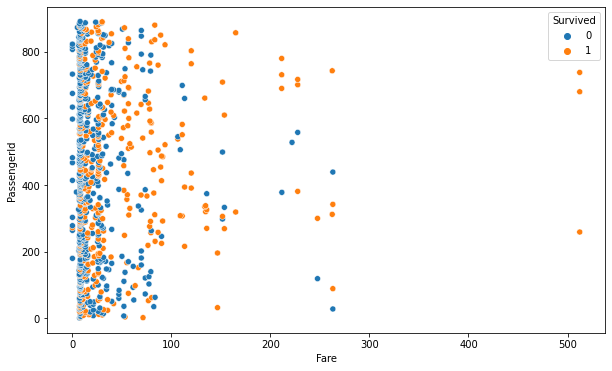

In [4]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Fare", y=data.index, hue="Survived", data=data)

In [5]:
outliers = data[data["Fare"] > 200].index
data.loc[outliers, "Fare"] = data["Fare"].median()

<AxesSubplot:xlabel='Fare', ylabel='PassengerId'>

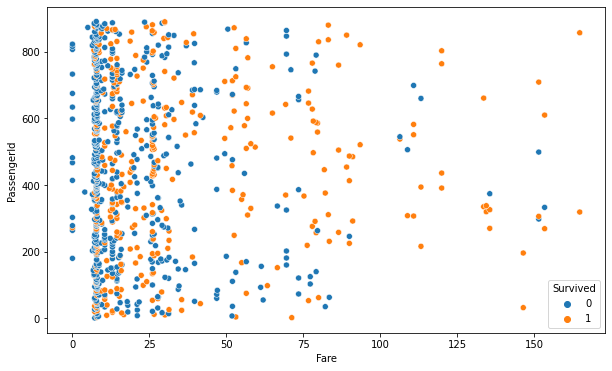

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Fare", y=data.index, hue="Survived", data=data)

## 3. Finding Mutual Information

In [7]:
def impute_data(data, *, num_strategy="mean", cat_strategy="most_frequent"):
    data = data.copy()
    index = data.index
    num_cols = data.select_dtypes(exclude="object").columns
    cat_cols = data.select_dtypes("object").columns
    
    num_imputer = SimpleImputer(strategy=num_strategy)
    cat_imputer = SimpleImputer(strategy=cat_strategy)
    
    data[num_cols] = pd.DataFrame(num_imputer.fit_transform(data[num_cols]), index=index, columns=num_cols)
    data[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(data[cat_cols]), index=index, columns=cat_cols)
    return data

In [8]:
def get_mi_score(X, y):
    X = impute_data(X.copy(), num_strategy="median")
    # Converting values of discrete features to numerical values
    for col in X.select_dtypes(["object"]):
        X[col] = X[col].factorize()[0]
    
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

In [9]:
X = data.copy()
Y = X.pop("Survived")
mi_scores = get_mi_score(X, Y)
mi_scores

Name        0.665912
Ticket      0.572496
Cabin       0.159859
Sex         0.150870
Fare        0.134668
Pclass      0.059235
SibSp       0.048427
Age         0.033732
Parch       0.027421
Embarked    0.014233
Name: MI Scores, dtype: float64

## 4. Selecting useful features

In [10]:
useful_features = mi_scores[mi_scores > 0.05].index
X = X[useful_features]
test_data = test_data[useful_features]
useful_features

Index(['Name', 'Ticket', 'Cabin', 'Sex', 'Fare', 'Pclass'], dtype='object')

## 5. Extracting numerical and categorical columns

In [11]:
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes("object").columns
num_cols, cat_cols

(Index(['Fare', 'Pclass'], dtype='object'),
 Index(['Name', 'Ticket', 'Cabin', 'Sex'], dtype='object'))

## 6. Making pipeline

In [12]:
class CreatePipeline:
    """Create Pipeline
    methods:
        pipeline: Create Final Pipeline
        
        create_model: Create the provided model
        
        numerical_transformer: Transform numerical cols
        
        categorical_transformer: Transform categorical cols \
        OneHotEncoding / OrdinalEncoding
        
        data_preprocessor: Preprocess the data using ColumnTransformer     
        """
    
    def pipeline(self, *, preprocessor, model, verbose=False):
        """Creates pipeline
        params:
            preprocessor
            model
        """
        steps = [("preprocessor", preprocessor),
                 ("model", model)]
        return Pipeline(steps=steps, verbose=verbose)
    
    
    def numerical_transformer(self, *, strategy="mean", **params):
        """Transform numerical columns using `SimpleImputer`.
        params:
            strategy: "mean" | "median" | "most_frequent" | "constant"
            **params: extra keyword args for SimpleImputer"""
        
        transformer = SimpleImputer(strategy=strategy, **params)
        return transformer

    
    def categorical_transformer(self, *, 
                                imp_strategy="most_frequent", 
                                encoder_type="Ordinal", 
                                imp_params={}, encoder_params={}):
        """Transform categorical columns by making Pipeline
        `SimpleImputer` | `OneHotEncoder` | `OrdinalEncoder`.
        args:
            imp_strategy: strategy for imputer values can be
                "most_frequent" | "constant"
            encoder_type: encoder type,
                "Ordinal" | "OneHot"
        kwargs:
            imp_params: keyword args for `SimpleImputer`.
            encoder_params: keyword args for encoder.`
        """
        if not encoder_type in ("Ordinal", "OneHot"):
            raise ValueError(f"Inappropriate value for encoder_type passed: {encoder_type}\
            Takes one of 'Ordinal' | 'OneHot'.")
        
        encoder = OrdinalEncoder if encoder_type=="Ordinal" else OneHotEncoder
        transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy=imp_strategy, **imp_params)),
            (encoder_type, encoder(**encoder_params))
        ])
        return transformer
    
    
    def data_preprocessor(self, *, transformers):
        """Preprocess the data using `ColumnTransformer`.
        Pass extact list of transformers
        to be passed in `ColumnTransformer`.
        each tuple consist of: (transformer_name,
                                transformer,
                                list_of_columns)."""
        preprocessor = ColumnTransformer(transformers=transformers)
        return preprocessor
    
    
    def create_model(self, *, model, random_state=0, n_estimators=1000, **kwargs):
        """Creates the model.
        **kwargs: keyword args for model."""
        my_model = model(random_state=random_state, n_estimators=n_estimators, **kwargs)
        return my_model

In [13]:
cp = CreatePipeline()
num_transformer = cp.numerical_transformer(strategy="median")
cat_transformer = cp.categorical_transformer(encoder_type="OneHot", encoder_params={"handle_unknown": "ignore"})
preprocessor = cp.data_preprocessor(
                    transformers=[("num", num_transformer, num_cols),
                                  ("cat", cat_transformer, cat_cols)
                                 ])

## 7. Doing hyperparameter tuning with cross-validation (`XGBRegressor`)

In [14]:
n_estimators = [500, 750, 1000]
max_depths = [5, 10]
learning_rate = [0.05, 0.1]
maes = {}
i = 0
for n in n_estimators:
    for md in max_depths:
        for rate in learning_rate:
            i += 1
            model = cp.create_model(model=XGBClassifier, n_estimators=n, max_depth=md, learning_rate=rate)
            pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
            scores = -1 * cross_val_score(pipeline, X, Y, cv=10, verbose=True,
                                    scoring="neg_mean_absolute_error")
            mae = scores.mean()
            maes[i] = [n, md, rate, mae]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

## 8. Checking MAE

In [15]:
for i in maes:
    n, md, rate, mae = maes[i]
    print(f"{i}.\tN_estimators: {n}\tmax_depth: {md}\tlearning_rate: {rate}\tMAE: {mae}")

1.	N_estimators: 500	max_depth: 5	learning_rate: 0.05	MAE: 0.1851310861423221
2.	N_estimators: 500	max_depth: 5	learning_rate: 0.1	MAE: 0.18848938826466916
3.	N_estimators: 500	max_depth: 10	learning_rate: 0.05	MAE: 0.1851310861423221
4.	N_estimators: 500	max_depth: 10	learning_rate: 0.1	MAE: 0.18851435705368288
5.	N_estimators: 750	max_depth: 5	learning_rate: 0.05	MAE: 0.18625468164794007
6.	N_estimators: 750	max_depth: 5	learning_rate: 0.1	MAE: 0.18848938826466916
7.	N_estimators: 750	max_depth: 10	learning_rate: 0.05	MAE: 0.18739076154806492
8.	N_estimators: 750	max_depth: 10	learning_rate: 0.1	MAE: 0.18739076154806492
9.	N_estimators: 1000	max_depth: 5	learning_rate: 0.05	MAE: 0.1918601747815231
10.	N_estimators: 1000	max_depth: 5	learning_rate: 0.1	MAE: 0.189625468164794
11.	N_estimators: 1000	max_depth: 10	learning_rate: 0.05	MAE: 0.18963795255930088
12.	N_estimators: 1000	max_depth: 10	learning_rate: 0.1	MAE: 0.18963795255930088


In [16]:
min(maes, key=lambda x: maes[x][3])

1

## 9. Best parameters
#### `n_estimators: 500`
#### `max_depth: 5`
#### `learning_rate: 0.05`

In [17]:
best_n_estimators = 500
best_max_depth = 5
best_rate = 0.05

## 10. Training model on best parameters

In [18]:
model = cp.create_model(model=XGBClassifier, n_estimators=best_n_estimators, learning_rate=best_rate, max_depth=best_max_depth)
pipeline = cp.pipeline(preprocessor=preprocessor, model=model)
pipeline.fit(X, Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['Fare', 'Pclass'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Name', 'Ticket', 'Cabin', 'Sex'], dtype='object'))])),
                ('model',
                 XGBClassifi...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, i

## 11. Predicting `Survived` on `test_data`

In [19]:
test_preds = pipeline.predict(test_data)
test_preds

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# 12. Submitting predictions

In [20]:
output = pd.DataFrame({"PassengerId": test_data.index, "Survived": test_preds})
output.to_csv("./data/submission_5.csv", index=False)